**Table of contents**<a id='toc0_'></a>    
- 1. [Load data         ](#toc1_)    
- 2. [Sub-figures     ](#toc2_)    
  - 2.1. [Nankai map    ](#toc2_1_)    
  - 2.2. [Japan trench map    ](#toc2_2_)    
  - 2.3. [Small map of Japan   ](#toc2_3_)    
  - 2.4. [Time series of Nankai tremor  ](#toc2_4_)    
  - 2.5. [Japan trench time series ](#toc2_5_)    
- 3. [Full figure](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [29]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import matplotlib.colors as mcolors
from matplotlib.dates import YearLocator
from matplotlib.ticker import MultipleLocator
import matplotlib.patheffects as fx

import rasterio
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.shapereader as shpreader

import os
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    workdir = '/Users/gaspard/Documents/work/'

In [2]:
def distance_epi(lon1, lat1, lon2, lat2):
    """Haversine formula to compute distance between two points on Earth

    Args:
        lon1 (float): longitude of point 1 (deg)
        lat1 (float): latitude of point 1 (deg)
        lon2 (float): longitude of point 2 (deg)
        lat2 (float): latitude of point 2 (deg)

    Returns:
        distance: distance between the two points (km)
    """
    R = 6371.0 # km
    dlon = np.radians(lon2 - lon1)
    dlat = np.radians(lat2 - lat1)

    a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    distance = R * c

    return distance


# 1. <a id='toc1_'></a>Load data          [&#128285;](#toc0_)

In [15]:
# Load catalogs
# Tremor
trm = pd.read_csv('../data/nankai/processed/nank_trm_0404_0413.csv', parse_dates=['date'])

# Earthquakes
eq = pd.read_csv('../data/nankai/processed/nank_eq_0404_0413.csv', parse_dates=['date'])

In [35]:
# Load results and extract results of interest
min_mag = 2.2
dist = 50
v_min = 3.5
dx_bin = 10
cc_thr = 0.07

# Load results
results = pickle.load(open('../results/nankai/nank_synch.pkl', 'rb'))

n_felt_eqs = results['n_felt_eqs']
corr_lengths = results['corr_lengths']

# Extract
n_felt_eq = n_felt_eqs[f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'][f'{dist:d}km']
corr_length = corr_lengths[f'dx{dx_bin:d}km'][f'v{v_min:.1f}kmd'][f'cc{cc_thr:.2f}']
n_tremor = results['n_tremors'][f'dx{dx_bin:d}km']
n_min_trm = results['parameters']['min_n_tremor_dx10km']

xmin = results['parameters']['xmin_bin']
xmax = results['parameters']['xmax_bin']
x_bin_edges = np.arange(xmin, xmax+dx_bin, dx_bin)

no_trm = n_tremor < n_min_trm
corr_length[no_trm] = np.nan
n_felt_eq[no_trm] = np.nan

In [16]:
# Slabs and trenches
# --> Pacific plate
# trench
path = workdir + "projects/data/Slabs/japan/japan_slabs_iwasaki2016/Trench/japan_trench_pos"
names = ['lon', 'lat', 'water_depth', '_', '__', '___']
pac_trench = pd.read_csv(path, sep=r'\s+', names=names)
pac_trench = pac_trench[['lon', 'lat', 'water_depth']]
pac_trench = pac_trench[pac_trench.lon > 0]
pac_trench.sort_values(by='lat', inplace=True)

# --> Philippine Sea plate
path = workdir + "projects/data/Slabs/japan/japan_slabs_iwasaki2016/PHS_Plate/phs_regional/phs_2015_5a_r_2017.xyz"
names = ['lon', 'lat', 'depth']
phs_slab = pd.read_csv(path, sep=r'\s+', names=names)
phs_slab.depth = -phs_slab.depth

# contours
dir_path = workdir + "projects/data/Slabs/japan/japan_slabs_iwasaki2016/PHS_Plate/phs_regional/contour/"

files = os.listdir(dir_path)
depths = [int(file.split('_')[2]) for file in files if file.endswith('rg')]
depths = np.sort(depths)

phs_slab_contours = dict()

for d in depths:
    path = dir_path + 'phs1_cntr_' + str(d) + '_rg'
    contour = np.loadtxt(path)
    contour = contour[:, :2]

    phs_slab_contours[d] = {'lon': contour[:, 0], 'lat': contour[:, 1]}
    in_range = np.where((contour[:, 0] > 0) | (contour[:, 1] > 0))[0]
    phs_slab_contours[d]['lon'] = phs_slab_contours[d]['lon'][in_range]
    phs_slab_contours[d]['lat'] = phs_slab_contours[d]['lat'][in_range]

# trench
path = workdir + "projects/data/Slabs/japan/japan_slabs_iwasaki2016/Trench/nankai_trough_pos"
names = ['lon', 'lat', 'water_depth', '_', '__', '___']
phs_trench = pd.read_csv(path, sep=r'\s+', names=names)
phs_trench = phs_trench[['lon', 'lat', 'water_depth']]
phs_trench = phs_trench[phs_trench.lon > 0]
phs_trench.sort_values(by='lon', inplace=True)

In [17]:
# Geographic boundaries
lon_min = trm.lon.min() - .5
lon_max = trm.lon.max() + .5
lat_min = trm.lat.min() - .5
lat_max = trm.lat.max() + .5

In [18]:
# Topography/bathymetry
path = workdir + "projects/data/Bathymetry/Global/gebco_2024_geotiff/gebco_2024_n90.0_s0.0_w90.0_e180.0.tif"

with rasterio.open(path) as src:
    dem = src.read(1, window=src.window(left=lon_min, right=lon_max, top=lat_max, bottom=lat_min))

# Spatial resolution
dlon, dlat = (lat_max - lat_min) / dem.shape[0], (lon_max - lon_min) / dem.shape[1]
dx = dlon * 111.32e3 * np.cos(np.radians(trm.lat.mean()))
dy = dlat * 111.32e3

# 2. <a id='toc2_'></a>Sub-figures      [&#128285;](#toc0_)

In [19]:
min_mag = 2.2  # minimum considered magnitude
max_dist = 50  # max distance for earthquakes "felt by tremor"

sci_adv_red = [183/255, 53/255, 47/255]

## 2.1. <a id='toc2_1_'></a>Nankai map     [&#128285;](#toc0_)

In [20]:
# Map parameters
crs = ccrs.Mercator(central_longitude=trm.lon.mean())

ms_trm_map = 1

c_trm_map = 'k'
c_eq_map = '.5'

figsize = np.array([4, 2.25])

In [21]:
# Make a "distance-from-tremor" field, to plot the 50 km contour
dist_lon = np.arange(lon_min-.1, lon_max+.1, .05)
dist_lat = np.arange(lat_min-.1, lat_max+.1, .05)

dist_lon, dist_lat = np.meshgrid(dist_lon, dist_lat)
shape = dist_lon.shape

dist_lon = dist_lon.reshape(-1)
dist_lat = dist_lat.reshape(-1)

dist_field = distance_epi(dist_lon[np.newaxis, :], dist_lat[np.newaxis, :], trm.lon.values[::2, np.newaxis], trm.lat.values[::2, np.newaxis])
dist_field = np.min(dist_field, axis=0)

dist_lon = dist_lon.reshape(*shape)
dist_lat = dist_lat.reshape(*shape)
dist_field = dist_field.reshape(*shape)

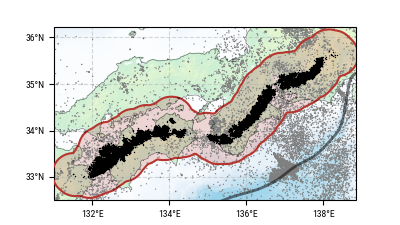

In [22]:
# Map
with plt.style.context('grl'):
    fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': crs})
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    ax.coastlines(resolution='10m', zorder=10, color=to_rgba('k', .5), lw=.5)

    # Add ticks
    ax.set_xticks(np.arange(np.ceil(lon_min), lon_max+1, 2), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(np.ceil(lat_min), lat_max, 1), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)

    # Add physical features on the map
    data_sea = dem.copy()
    data_land = dem.copy()
    data_sea = data_sea.astype(float)
    data_land = data_land.astype(float)
    data_sea[data_sea > -10] = np.nan
    data_land[data_land < 10] = np.nan

    ls = mcolors.LightSource(azdeg=315, altdeg=45)
    sea_colors = plt.cm.Blues_r(np.linspace(.5, 1, 128))
    land_colors = plt.cm.YlGnBu_r(np.linspace(0.7, 1., 128))
    combined_colors = np.vstack((sea_colors, land_colors))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_terrain', combined_colors)

    data_rgb = ls.shade(dem, cmap=mymap, blend_mode='soft', vert_exag=1, dx=dx, dy=dy, vmin=-5000, vmax=5000)
    ax.imshow(data_rgb, transform=ccrs.PlateCarree(), extent=[lon_min, lon_max, lat_min, lat_max], zorder=0)
    
    # Plot tremor
    ax.plot(trm.lon, trm.lat, 'o', transform=ccrs.PlateCarree(), ms=ms_trm_map, mfc=c_trm_map, mec='none', zorder=3)

    # Plot earthquakes
    eq_in_map = (eq.lon > lon_min) & (eq.lon < lon_max) & (eq.lat > lat_min) & (eq.lat < lat_max) & (eq.mag > min_mag)
    ax.scatter(eq[eq_in_map].lon, eq[eq_in_map].lat, transform=ccrs.PlateCarree(), s=eq[eq_in_map].mag/3, c=c_eq_map, edgecolor='none', zorder=2)

    # Show 50 km distance field
    ax.contour(dist_lon, dist_lat, dist_field, levels=[max_dist], colors=[sci_adv_red], transform=ccrs.PlateCarree(), zorder=4)
    ax.contourf(dist_lon, dist_lat, dist_field, levels=[0, max_dist], colors=[to_rgba(sci_adv_red, .2)], transform=ccrs.PlateCarree(), zorder=0)

    # Show trench
    ax.plot(phs_trench.lon, phs_trench.lat, transform=ccrs.PlateCarree(), c=to_rgba('k', .5), lw=2, zorder=2)
    ax.plot(pac_trench.lon, pac_trench.lat, transform=ccrs.PlateCarree(), c=to_rgba('k', .5), lw=2, zorder=2)

    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    plt.show()

## 2.3. <a id='toc2_3_'></a>Small map of Japan    [&#128285;](#toc0_)

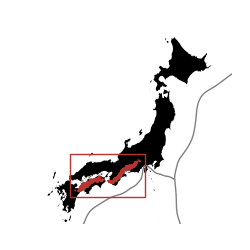

In [23]:
# Plot
fig, ax = plt.subplots(figsize=(2.5, 2.5), subplot_kw={"projection":crs})
ax.axis('off')

ax.set_extent([125.5, 148, 30, 46])
shpfilename = shpreader.natural_earth(resolution='10m',
                                    category='cultural',
                                    name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

japan = None
for country in countries:
    if country.attributes['NAME'] == 'Japan':
        japan = country.geometry
ax.plot(phs_trench.lon, phs_trench.lat, transform=ccrs.PlateCarree(), c='.5', lw=1, zorder=2)
ax.plot(pac_trench.lon, pac_trench.lat, transform=ccrs.PlateCarree(), c='.5', lw=1, zorder=2)

ax.add_geometries([japan], ccrs.PlateCarree(), facecolor='k', zorder=1)
ax.add_patch(plt.Rectangle((lon_min, lat_min), lon_max-lon_min, lat_max-lat_min, transform=ccrs.PlateCarree(),
                                    facecolor='none', edgecolor=sci_adv_red, lw=1, zorder=3))
ax.scatter(trm.lon, trm.lat, s=1, c=[sci_adv_red], edgecolors='none', transform=ccrs.PlateCarree(), zorder=4)

plt.tight_layout()
plt.show()

## 2.4. <a id='toc2_4_'></a>Time series of Nankai tremor   [&#128285;](#toc0_)

In [27]:
# Time series parameters
ms_trm_ts = 1.5

c_trm_ts = c_trm_map
c_eq_ts = to_rgba(sci_adv_red, 1)

figsize = np.array([10, 3])

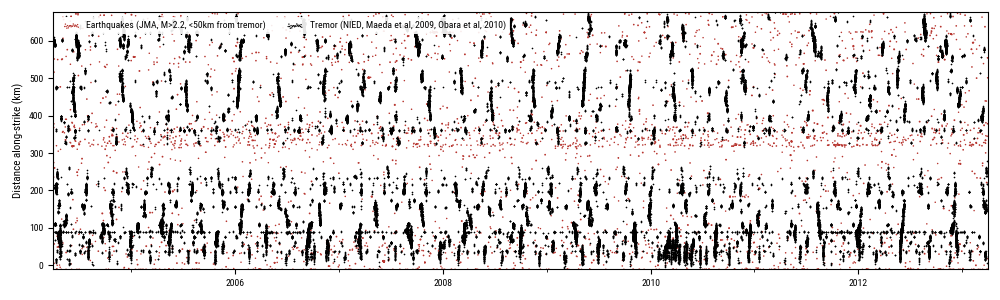

In [28]:
# Plot
with plt.style.context('grl'):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_ylabel('Distance along-strike (km)')

    ax.plot(trm.date, trm.xf, 'o', ms=1.2, mfc=c_trm_ts, mec='none', zorder=2)
    ax.scatter(eq[(eq.dist2trm < max_dist) & (eq.mag > min_mag)].date, eq[(eq.dist2trm < max_dist) & (eq.mag > min_mag)].xf, s=eq[(eq.dist2trm < max_dist) & (eq.mag > min_mag)].mag/2, c=[c_eq_ts], edgecolors='none', zorder=1)
    
    ax.set_xlim([trm.date.min(), trm.date.max()])
    ax.set_ylim([eq.xf.min(), eq.xf.max()])

    # Legend
    ax.scatter([], [], s=1, c=[c_eq_ts], edgecolors='none', label=f'Earthquakes (JMA, M>{min_mag:.1f}, <{max_dist:d}km from tremor)')
    ax.scatter([], [], s=1, c=[c_trm_ts], edgecolors='none', label='Tremor (NIED, Maeda et al, 2009, Obara et al, 2010)')
    ax.legend(loc='upper left', framealpha=.9, scatteryoffsets=.4 + np.random.randn(20)*.2, scatterpoints=20, handletextpad=.5, edgecolor='none', ncol=2)

    # Ticks
    ax.xaxis.set_major_locator(YearLocator(2))
    ax.xaxis.set_minor_locator(YearLocator(1))

    plt.tight_layout()
    plt.show()

## Measurement results

In [32]:
# Figure parameters
figsize = np.array([2, 3])

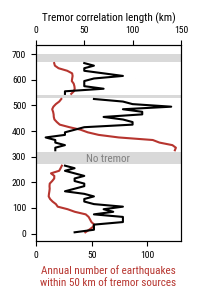

In [ ]:
# Histogram
with plt.style.context('grl'):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlabel('Annual number of earthquakes\nwithin 50 km of tremor sources', c=sci_adv_red)
    ax.set_xlim(0, 130)

    ax.plot(n_felt_eq, x_bin_edges[:-1]+dx_bin/2, c=sci_adv_red)

    ax_cc = ax.twiny()
    ax_cc.set_xlim(0, 150)
    ax_cc.plot(corr_length, x_bin_edges[:-1]+dx_bin/2, 'k')
    ax_cc.set_xlabel('Tremor correlation length (km)')

    for ii in np.where(no_trm)[0]:
        ax.axhspan(x_bin_edges[ii], x_bin_edges[ii+1], fc='.85', ec='none', zorder=0)
    
    ax.text(65, 290, 'No tremor', color='.5', ha='center', va='center', fontsize=8)

    plt.tight_layout()
    plt.show()

# 3. <a id='toc3_'></a>Full figure [&#128285;](#toc0_)

In [67]:
# Parameters
# --> Maps parameters
crs = ccrs.Mercator(central_longitude=trm.lon.mean())

ms_trm_map = 1

c_trm_map = 'k'
c_eq_map = '.5'

# --> Time series parameters
ms_trm_ts = 1

c_trm_ts = c_trm_map
c_eq_ts = to_rgba(sci_adv_red, 1)

# --> Figure layout
figsize = (7.24, 3)
adj_dict = dict(bottom=.07, top=.93, left=.07, right=.98, wspace=.2, hspace=.2)

heights = [0.5, 0.5]
widths = [2, 5, .8]

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_31120/3213497518.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


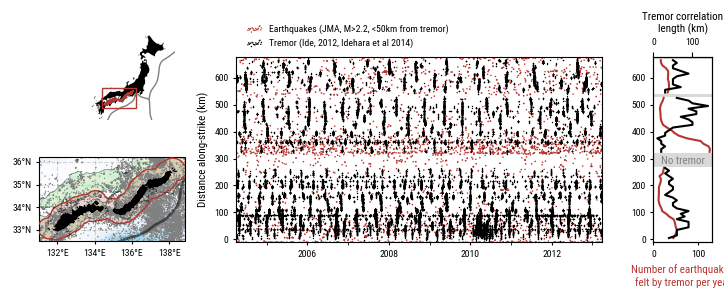

In [84]:
with plt.style.context('grl'):
    
    fig = plt.figure(figsize=figsize, facecolor='.95')
    gs = fig.add_gridspec(2, 3, height_ratios=heights, width_ratios=widths)

    # Japan Map -----------------------------------------------------------------------------------
    ax = plt.axes([0.1, 0.6, 0.15, 0.3], projection=crs)
    ax.axis('off')

    ax.set_extent([125.5, 148, 30, 46])
    shpfilename = shpreader.natural_earth(resolution='10m',
                                        category='cultural',
                                        name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    countries = reader.records()

    japan = None
    for country in countries:
        if country.attributes['NAME'] == 'Japan':
            japan = country.geometry
    ax.plot(phs_trench.lon, phs_trench.lat, transform=ccrs.PlateCarree(), c='.5', lw=1, zorder=2)
    ax.plot(pac_trench.lon, pac_trench.lat, transform=ccrs.PlateCarree(), c='.5', lw=1, zorder=2)

    ax.add_geometries([japan], ccrs.PlateCarree(), facecolor='k', zorder=1)
    ax.add_patch(plt.Rectangle((lon_min, lat_min), lon_max-lon_min, lat_max-lat_min, transform=ccrs.PlateCarree(),
                                        facecolor='none', edgecolor=sci_adv_red, lw=1, zorder=3))
    ax.scatter(trm.lon, trm.lat, s=1, c=[sci_adv_red], edgecolors='none', transform=ccrs.PlateCarree(), zorder=4)

    # Nankai Map -----------------------------------------------------------------------------------
    ax = fig.add_subplot(gs[1, 0], projection=crs)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    ax.coastlines(resolution='10m', zorder=10, color=to_rgba('k', .5), lw=.5)

    # Add ticks
    ax.set_xticks(np.arange(np.ceil(lon_min), lon_max+1, 2), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(np.ceil(lat_min), lat_max, 1), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)
    ax.tick_params(length=2)

    # Add physical features on the map
    data_sea = dem.copy()
    data_land = dem.copy()
    data_sea = data_sea.astype(float)
    data_land = data_land.astype(float)
    data_sea[data_sea > -10] = np.nan
    data_land[data_land < 10] = np.nan

    ls = mcolors.LightSource(azdeg=315, altdeg=45)
    sea_colors = plt.cm.Blues_r(np.linspace(.5, 1, 128))
    land_colors = plt.cm.YlGnBu_r(np.linspace(0.7, 1., 128))
    combined_colors = np.vstack((sea_colors, land_colors))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_terrain', combined_colors)

    data_rgb = ls.shade(dem, cmap=mymap, blend_mode='soft', vert_exag=1, dx=dx, dy=dy, vmin=-5000, vmax=5000)
    ax.imshow(data_rgb, transform=ccrs.PlateCarree(), extent=[lon_min, lon_max, lat_min, lat_max], zorder=0)
    
    # Plot tremor
    ax.plot(trm.lon, trm.lat, 'o', transform=ccrs.PlateCarree(), ms=ms_trm_map, mfc=c_trm_map, mec='none', zorder=3)

    # Plot earthquakes
    eq_in_map = (eq.lon > lon_min) & (eq.lon < lon_max) & (eq.lat > lat_min) & (eq.lat < lat_max) & (eq.mag > min_mag)
    ax.scatter(eq[eq_in_map].lon, eq[eq_in_map].lat, transform=ccrs.PlateCarree(), s=eq[eq_in_map].mag/3, c=c_eq_map, edgecolor='none', zorder=2)

    # Show 50 km distance field
    ax.contour(dist_lon, dist_lat, dist_field, levels=[max_dist], colors=[sci_adv_red], transform=ccrs.PlateCarree(), linewidths=[1], zorder=4)
    ax.contourf(dist_lon, dist_lat, dist_field, levels=[0, max_dist], colors=[to_rgba(sci_adv_red, .2)], transform=ccrs.PlateCarree(), zorder=0)

    # Show trench
    ax.plot(phs_trench.lon, phs_trench.lat, transform=ccrs.PlateCarree(), c=to_rgba('k', .5), lw=2, zorder=2)
    ax.plot(pac_trench.lon, pac_trench.lat, transform=ccrs.PlateCarree(), c=to_rgba('k', .5), lw=2, zorder=2)

    ax.set_extent([lon_min, lon_max, lat_min, lat_max])

    # ax.scatter([], [], color=c_trm_map, edgecolors='none', s=2, label='Tremor')
    # ax.scatter([], [], color=c_eq_map, edgecolors='none', s=2, label='Earthquakes (M>2.2)')
    # ax.plot([], [], ls='-', c=sci_adv_red, label='50 km from tremor')
    # ax.legend(loc='upper left', bbox_to_anchor=(-.1, -.2), fontsize='small', framealpha=0, scatteryoffsets=.4 + np.random.randn(20)*.2, scatterpoints=20, handletextpad=.5, edgecolor='none', ncol=2)


    # Time series -----------------------------------------------------------------------------------
    ax = fig.add_subplot(gs[:, 1])
    ax.set_ylabel('Distance along-strike (km)')

    ax.plot(trm.date, trm.xf, 'o', ms=ms_trm_ts, mfc=c_trm_ts, mec='none', zorder=2)
    ax.scatter(eq[(eq.dist2trm < max_dist) & (eq.mag > min_mag)].date, eq[(eq.dist2trm < max_dist) & (eq.mag > min_mag)].xf, s=eq[(eq.dist2trm < max_dist) & (eq.mag > min_mag)].mag/2, c=[c_eq_ts], edgecolors='none', zorder=1)
    
    ax.set_xlim([trm.date.min(), trm.date.max()])
    ax.set_ylim([eq.xf.min(), eq.xf.max()])

    # Legend
    ax.scatter([], [], s=1, c=[c_eq_ts], edgecolors='none', label=f'Earthquakes (JMA, M>{min_mag:.1f}, <{max_dist:d}km from tremor)')
    ax.scatter([], [], s=1, c=[c_trm_ts], edgecolors='none', label='Tremor (Ide, 2012, Idehara et al 2014)')
    ax.legend(bbox_to_anchor=(0, 1), loc='lower left', framealpha=.9, scatteryoffsets=.4 + np.random.randn(20)*.2, scatterpoints=20, handletextpad=.5, edgecolor='none')

    # Ticks
    ax.xaxis.set_major_locator(YearLocator(2))
    ax.xaxis.set_minor_locator(YearLocator(1))

    ax.yaxis.set_major_locator(MultipleLocator(100))

    ax.tick_params(length=2)


    # Histogram -----------------------------------------------------------------------------------
    ax = fig.add_subplot(gs[:, -1], sharey=ax)
    ax.set_xlabel('Number of earthquakes\nfelt by tremor per year', c=sci_adv_red)
    ax.set_xlim(0, 130)

    ax.plot(n_felt_eq, x_bin_edges[:-1]+dx_bin/2, c=sci_adv_red)

    ax_cc = ax.twiny()
    ax_cc.set_xlim(0, 150)
    ax_cc.plot(corr_length, x_bin_edges[:-1]+dx_bin/2, 'k')
    ax_cc.set_xlabel('Tremor correlation\nlength (km)')

    for ii in np.where(no_trm)[0]:
        ax.axhspan(x_bin_edges[ii], x_bin_edges[ii+1], fc='.85', ec='none', zorder=0)
    
    ax.text(65, 290, 'No tremor', color='.5', ha='center', va='center', fontsize=8)

    ax.tick_params(length=2)

    plt.tight_layout()
    plt.savefig('../figures/nankai_main_figure.pdf')
    plt.show()